# Day 6  | Linear regression

The first day of the second week with advanced Python will start with supervised machine learning methods.
We will introduce linear regression and its applicability in fitting the data to a straight line or plane in higher dimensions.

Linear regression models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.
We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plotter
import numpy as np

### Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

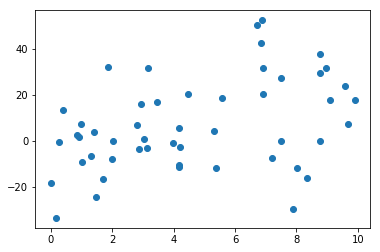

In [53]:
rng = np.random.RandomState(1)
a = 2
b = 5
x = 10 * rng.rand(50)
y = a * x - b + 20*rng.randn(50)
plotter.scatter(x, y);

In [42]:
x.shape

(50,)

In [44]:
x[:, np.newaxis].shape

(50, 1)

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

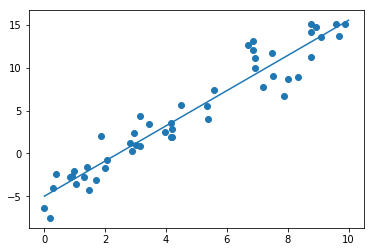

In [49]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plotter.scatter(x, y)
plotter.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [51]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.054417620721391
Model intercept: -4.997154171106412


We see that the results are very close to the inputs, as we might hope.

# The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [52]:
X = 10 * rng.rand(100, 2)
y = 0.5 + np.dot(X, [1.5, -2.])

model.fit(X, y)
print(model.coef_)
print(model.intercept_)


[ 1.5 -2. ]
0.4999999999999969


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [54]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.
Let's make a 7th-degree polynomial model in this way:

In [83]:
from sklearn.pipeline import make_pipeline
degree = 3
poly_model = make_pipeline(PolynomialFeatures(degree),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

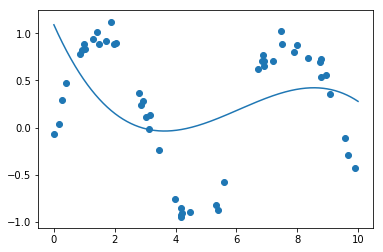

In [84]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plotter.scatter(x, y)
plotter.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

### Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases.
The result might look something like the following figure:

These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them; reading Scikit-Learn's source is a good way to see how they can be created):

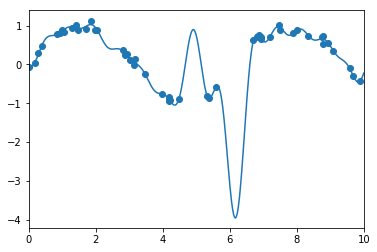

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(30),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plotter.scatter(x, y)
plotter.plot(xfit, yfit)
plotter.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

### Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.
For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

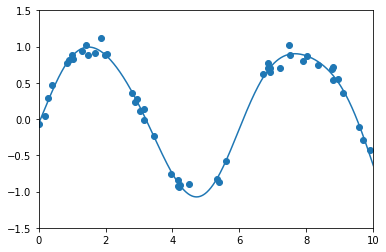

In [87]:
model = make_pipeline(GaussianFeatures(10),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plotter.scatter(x, y)
plotter.plot(xfit, model.predict(xfit[:, np.newaxis]))

plotter.xlim(0, 10)
plotter.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

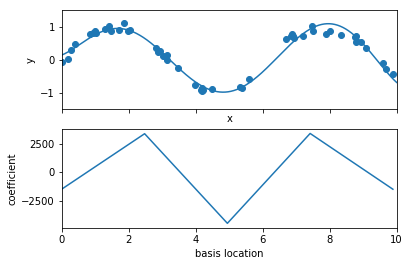

In [117]:
def basis_plot(model, title=None):
    fig, ax = plotter.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(5), LinearRegression())
model.fit(x[:, np.newaxis], y)
basis_plot(model)


The lower panel of this figure shows the amplitude of the basis function at each location.
This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out.
We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters.
Such a penalty is known as *regularization*, and comes in several forms.

###### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

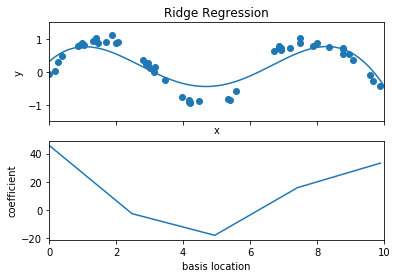

In [118]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(5), Ridge(alpha=0.001))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

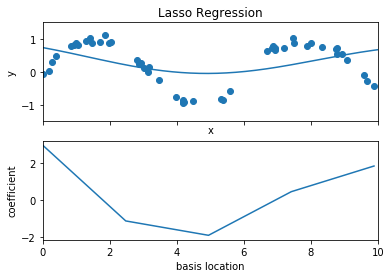

In [112]:
from sklearn.linear_model import ElasticNet
model = make_pipeline(GaussianFeatures(5), ElasticNet(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.